In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle

class SkeletonDataset(Dataset):
    """
    Custom Dataset cho dữ liệu skeleton.
    Đọc dữ liệu từ file .npy và label từ file .pkl,
    sau đó định hình lại cho phù hợp với mô hình RNN/GRU.
    """
    def __init__(self, data_path, label_path):
        # Tải label
        with open(label_path, 'rb') as f:
            self.labels = pickle.load(f)

        # Tải dữ liệu và chuyển sang tensor
        # Dữ liệu gốc có shape (N, C, T, V, M)
        raw_data = np.load(data_path)
        self.data = torch.from_numpy(raw_data).float()

        # Thông tin shape
        self.N, self.C, self.T, self.V, self.M = self.data.shape
        print(f"Loaded data from {data_path} with shape: ({self.N}, {self.C}, {self.T}, {self.V}, {self.M})")


    def __len__(self):
        return self.N

    def __getitem__(self, index):
        # Lấy dữ liệu và label tại index
        sample_data = self.data[index] # Shape: (C, T, V, M)
        label = self.labels[index]

        # Thay đổi shape để phù hợp với GRU
        # Chuyển (C, T, V, M) -> (T, C, V, M)
        sample_data = sample_data.permute(1, 0, 2, 3)

        # Làm phẳng các chiều C, V, M thành một vector đặc trưng duy nhất cho mỗi bước thời gian T
        # Shape sau khi làm phẳng: (T, C * V * M)
        # Ví dụ: (20, 3 * 61 * 1) = (20, 183)
        flattened_data = sample_data.reshape(self.T, -1)

        return flattened_data, torch.tensor(label, dtype=torch.long)

In [16]:
import random
def set_seed(seed_value):
    random.seed(seed_value) # Python's random module
    np.random.seed(seed_value) # NumPy
    torch.manual_seed(seed_value) # PyTorch on CPU
    torch.cuda.manual_seed_all(seed_value) # PyTorch on all GPUs (if available)
    
    # Cấu hình cho thuật toán cuDNN (thường được sử dụng bởi PyTorch trên GPU)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"Global seed set to {seed_value}")

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdvancedGRUModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AdvancedGRUModel, self).__init__()

        # --- Lớp GRU ---
        # Keras: GRU(128, return_sequences=True, activation='relu')
        # PyTorch: nn.GRU không hỗ trợ trực tiếp activation='relu'. 
        # Chúng ta sẽ sử dụng nn.GRU tiêu chuẩn và thảo luận về điểm này bên dưới.
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0)

        self.gru2 = nn.GRU(input_size=128, hidden_size=128, batch_first=True)
        self.dropout2 = nn.Dropout(0)

        self.gru3 = nn.GRU(input_size=128, hidden_size=256, batch_first=True)
        self.dropout3 = nn.Dropout(0)
        
        self.gru4 = nn.GRU(input_size=256, hidden_size=512, batch_first=True)
        self.dropout4 = nn.Dropout(0)

        # Lớp GRU cuối cùng, tương đương return_sequences=False
        self.gru5 = nn.GRU(input_size=512, hidden_size=512, batch_first=True)

        # --- Khối Classifier (MLP) ---
        # Sử dụng nn.Sequential để nhóm các lớp Dense lại cho gọn gàng
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(512),       # Tương đương BatchNormalization() sau GRU
            nn.Linear(512, 512),
            nn.ReLU(),                 # Tương đương activation='relu'
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes) # Lớp output, không có softmax (xem giải thích)
        )

    def forward(self, x):
        # Luồng dữ liệu qua các lớp GRU
        # self.gru(x) trả về (output, h_n)
        # output có shape (batch, seq_len, hidden_size)
        # h_n là hidden state cuối cùng
        
        # return_sequences=True
        out, _ = self.gru1(x)
        out = self.dropout1(out)
        
        out, _ = self.gru2(out)
        out = self.dropout2(out)

        out, _ = self.gru3(out)
        out = self.dropout3(out)

        out, _ = self.gru4(out)
        out = self.dropout4(out)

        # Lớp GRU cuối, tương đương return_sequences=False
        out, _ = self.gru5(out)
        
        # Lấy output của bước thời gian cuối cùng
        out = out[:, -1, :] # Shape: (batch, hidden_size)

        # Cho qua khối classifier
        out = self.classifier(out)
        
        return out

In [18]:
from tqdm import tqdm

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Hàm huấn luyện model trong một epoch."""
    model.train()  # Chuyển model sang chế độ training
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Thống kê
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    """Hàm đánh giá model trên tập validation hoặc test."""
    model.eval()  # Chuyển model sang chế độ evaluation
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Không cần tính gradient khi đánh giá
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Thống kê
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [19]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward + loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward + clip grads
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Step optimizer + scheduler
        optimizer.step()
        scheduler.step()

        # Stats
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

In [20]:
from torch.optim.lr_scheduler import OneCycleLR

In [21]:
if __name__ == '__main__':
    # --- 1. Cấu hình & Hyperparameters ---
    DATA_DIR     = '/workspace/data/npy_100/transformed/mediapipe61'
    NUM_CLASSES  = 2139
    NUM_EPOCHS   = 100
    BATCH_SIZE   = 256
    LEARNING_RATE= 0.001

    set_seed(42)

    # --- 2. Chuẩn bị Dữ liệu ---
    train_dataset = SkeletonDataset(f'{DATA_DIR}/train_data.npy', f'{DATA_DIR}/train_label.pkl')
    val_dataset   = SkeletonDataset(f'{DATA_DIR}/eval_data.npy',   f'{DATA_DIR}/eval_label.pkl')
    test_dataset  = SkeletonDataset(f'{DATA_DIR}/test_data.npy',  f'{DATA_DIR}/test_label.pkl')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # --- 3. Model, Loss, Optimizer, Scheduler ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = AdvancedGRUModel(input_size=3*61*1, num_classes=NUM_CLASSES).to(device)
    print("--- Model Architecture ---")
    print(model)
    print("--------------------------")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    scheduler = OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE * 5,
        steps_per_epoch=len(train_loader),
        epochs=NUM_EPOCHS,
        pct_start=0.3,
        div_factor=25.0,
        final_div_factor=1e4
    )

    # --- 4. Training Loop ---
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"\n--- Epoch {epoch}/{NUM_EPOCHS} ---")
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion,
            optimizer, scheduler, device
        )
        print(f"Train  | Loss: {train_loss:.4f}  Acc: {train_acc:.4f}")

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        print(f"Val    | Loss: {val_loss:.4f}  Acc: {val_acc:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    # --- 5. Final Test ---
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"\nTest   | Loss: {test_loss:.4f}  Acc: {test_acc:.4f}")
    torch.save(model.state_dict(), '/workspace/data/log/hdf5/gru_model_100.pth')
    print("Model saved to advanced_gru_model.pth")

Global seed set to 42


Loaded data from /workspace/data/npy_100/transformed/mediapipe61/train_data.npy with shape: (256680, 3, 24, 61, 1)
Loaded data from /workspace/data/npy_100/transformed/mediapipe61/eval_data.npy with shape: (85560, 3, 24, 61, 1)
Loaded data from /workspace/data/npy_100/transformed/mediapipe61/test_data.npy with shape: (85560, 3, 24, 61, 1)
Using device: cuda
--- Model Architecture ---
AdvancedGRUModel(
  (gru1): GRU(183, 128, batch_first=True)
  (dropout1): Dropout(p=0, inplace=False)
  (gru2): GRU(128, 128, batch_first=True)
  (dropout2): Dropout(p=0, inplace=False)
  (gru3): GRU(128, 256, batch_first=True)
  (dropout3): Dropout(p=0, inplace=False)
  (gru4): GRU(256, 512, batch_first=True)
  (dropout4): Dropout(p=0, inplace=False)
  (gru5): GRU(512, 512, batch_first=True)
  (classifier): Sequential(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_fe

Training: 100%|██████████| 1003/1003 [00:12<00:00, 77.87it/s]


Train  | Loss: 5.7922  Acc: 0.0173


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 160.22it/s]


Val    | Loss: 4.5057  Acc: 0.0332

--- Epoch 2/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.20it/s]


Train  | Loss: 3.7724  Acc: 0.0815


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 157.49it/s]


Val    | Loss: 4.2297  Acc: 0.0510

--- Epoch 3/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 84.27it/s]


Train  | Loss: 3.2450  Acc: 0.1299


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 159.13it/s]


Val    | Loss: 3.5035  Acc: 0.0922

--- Epoch 4/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.87it/s]


Train  | Loss: 2.5412  Acc: 0.2472


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 155.40it/s]


Val    | Loss: 2.7091  Acc: 0.2263

--- Epoch 5/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 85.76it/s]


Train  | Loss: 1.9816  Acc: 0.3697


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 147.08it/s]


Val    | Loss: 2.9093  Acc: 0.2661

--- Epoch 6/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 86.41it/s]


Train  | Loss: 1.4934  Acc: 0.5194


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 146.50it/s]


Val    | Loss: 1.3488  Acc: 0.5696

--- Epoch 7/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.41it/s]


Train  | Loss: 0.7928  Acc: 0.7419


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 157.26it/s]


Val    | Loss: 0.5747  Acc: 0.8137

--- Epoch 8/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.33it/s]


Train  | Loss: 0.4874  Acc: 0.8419


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 155.08it/s]


Val    | Loss: 0.3870  Acc: 0.8761

--- Epoch 9/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 77.06it/s]


Train  | Loss: 0.3208  Acc: 0.8982


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 146.55it/s]


Val    | Loss: 0.4186  Acc: 0.8656

--- Epoch 10/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.59it/s]


Train  | Loss: 0.2435  Acc: 0.9242


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 146.52it/s]


Val    | Loss: 0.9894  Acc: 0.7414

--- Epoch 11/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 74.88it/s]


Train  | Loss: 0.2122  Acc: 0.9343


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 148.05it/s]


Val    | Loss: 1.0996  Acc: 0.7241

--- Epoch 12/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 77.14it/s]


Train  | Loss: 0.1952  Acc: 0.9408


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 147.22it/s]


Val    | Loss: 0.2281  Acc: 0.9256

--- Epoch 13/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.95it/s]


Train  | Loss: 0.1854  Acc: 0.9445


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 143.85it/s]


Val    | Loss: 4.2172  Acc: 0.4144

--- Epoch 14/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 74.72it/s]


Train  | Loss: 0.1722  Acc: 0.9496


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 149.01it/s]


Val    | Loss: 0.7812  Acc: 0.8216

--- Epoch 15/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 73.24it/s]


Train  | Loss: 0.1677  Acc: 0.9517


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 144.14it/s]


Val    | Loss: 0.3245  Acc: 0.9158

--- Epoch 16/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.55it/s]


Train  | Loss: 0.1630  Acc: 0.9532


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 143.73it/s]


Val    | Loss: 0.3728  Acc: 0.8972

--- Epoch 17/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.82it/s]


Train  | Loss: 0.1526  Acc: 0.9571


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 154.87it/s]


Val    | Loss: 1.9751  Acc: 0.6831

--- Epoch 18/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.76it/s]


Train  | Loss: 0.1539  Acc: 0.9578


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 156.42it/s]


Val    | Loss: 5.5947  Acc: 0.3778

--- Epoch 19/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.72it/s]


Train  | Loss: 0.1475  Acc: 0.9597


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 154.38it/s]


Val    | Loss: 1.0314  Acc: 0.8081

--- Epoch 20/100 ---


Training: 100%|██████████| 1003/1003 [00:14<00:00, 67.77it/s]


Train  | Loss: 0.1449  Acc: 0.9612


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 148.32it/s]


Val    | Loss: 7.3751  Acc: 0.3092

--- Epoch 21/100 ---


Training: 100%|██████████| 1003/1003 [00:14<00:00, 69.94it/s]


Train  | Loss: 0.1421  Acc: 0.9619


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 154.98it/s]


Val    | Loss: 0.6143  Acc: 0.8711

--- Epoch 22/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.38it/s]


Train  | Loss: 0.1445  Acc: 0.9623


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 155.63it/s]


Val    | Loss: 9.6052  Acc: 0.3363

--- Epoch 23/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 73.12it/s]


Train  | Loss: 0.1519  Acc: 0.9614


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 155.85it/s]


Val    | Loss: 3.0838  Acc: 0.6331

--- Epoch 24/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 85.74it/s]


Train  | Loss: 0.1574  Acc: 0.9604


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 154.16it/s]


Val    | Loss: 0.6474  Acc: 0.8770

--- Epoch 25/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 72.41it/s]


Train  | Loss: 0.1701  Acc: 0.9596


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.29it/s]


Val    | Loss: 1.3851  Acc: 0.7728

--- Epoch 26/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.95it/s]


Train  | Loss: 0.1817  Acc: 0.9579


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.15it/s]


Val    | Loss: 3.9940  Acc: 0.6150

--- Epoch 27/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 73.92it/s]


Train  | Loss: 0.1879  Acc: 0.9588


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 169.22it/s]


Val    | Loss: 1.2105  Acc: 0.8302

--- Epoch 28/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 85.50it/s]


Train  | Loss: 0.2039  Acc: 0.9572


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 168.53it/s]


Val    | Loss: 8.1143  Acc: 0.3920

--- Epoch 29/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.39it/s]


Train  | Loss: 0.2121  Acc: 0.9571


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.20it/s]


Val    | Loss: 7.5360  Acc: 0.4930

--- Epoch 30/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 74.56it/s]


Train  | Loss: 0.2198  Acc: 0.9569


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.31it/s]


Val    | Loss: 10.7847  Acc: 0.4329

--- Epoch 31/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 84.05it/s]


Train  | Loss: 0.2260  Acc: 0.9581


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.43it/s]


Val    | Loss: 0.4657  Acc: 0.9231

--- Epoch 32/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 72.65it/s]


Train  | Loss: 0.2403  Acc: 0.9566


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 164.37it/s]


Val    | Loss: 16.4154  Acc: 0.3315

--- Epoch 33/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 86.65it/s]


Train  | Loss: 0.2526  Acc: 0.9577


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.86it/s]


Val    | Loss: 0.7505  Acc: 0.8959

--- Epoch 34/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 84.37it/s]


Train  | Loss: 0.2509  Acc: 0.9588


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.12it/s]


Val    | Loss: 3.6894  Acc: 0.6608

--- Epoch 35/100 ---


Training: 100%|██████████| 1003/1003 [00:14<00:00, 71.57it/s]


Train  | Loss: 0.2624  Acc: 0.9594


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 169.90it/s]


Val    | Loss: 2.2040  Acc: 0.8049

--- Epoch 36/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 87.33it/s]


Train  | Loss: 0.2801  Acc: 0.9599


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 168.57it/s]


Val    | Loss: 2.5291  Acc: 0.7959

--- Epoch 37/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 84.23it/s]


Train  | Loss: 0.2809  Acc: 0.9610


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 164.59it/s]


Val    | Loss: 1.6820  Acc: 0.8749

--- Epoch 38/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.07it/s]


Train  | Loss: 0.2772  Acc: 0.9625


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.63it/s]


Val    | Loss: 2.9317  Acc: 0.7808

--- Epoch 39/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 85.70it/s]


Train  | Loss: 0.2857  Acc: 0.9638


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.14it/s]


Val    | Loss: 1.0949  Acc: 0.8895

--- Epoch 40/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.05it/s]


Train  | Loss: 0.2895  Acc: 0.9648


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 168.68it/s]


Val    | Loss: 0.7644  Acc: 0.9212

--- Epoch 41/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.30it/s]


Train  | Loss: 0.2939  Acc: 0.9653


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.57it/s]


Val    | Loss: 1.5875  Acc: 0.8848

--- Epoch 42/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 86.28it/s]


Train  | Loss: 0.3020  Acc: 0.9679


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 167.77it/s]


Val    | Loss: 0.7495  Acc: 0.9425

--- Epoch 43/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 87.20it/s]


Train  | Loss: 0.3119  Acc: 0.9687


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.44it/s]


Val    | Loss: 0.5523  Acc: 0.9522

--- Epoch 44/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.61it/s]


Train  | Loss: 0.3131  Acc: 0.9700


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.57it/s]


Val    | Loss: 1.0029  Acc: 0.9288

--- Epoch 45/100 ---


Training: 100%|██████████| 1003/1003 [00:14<00:00, 68.46it/s]


Train  | Loss: 0.3331  Acc: 0.9703


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 163.32it/s]


Val    | Loss: 9.8925  Acc: 0.6338

--- Epoch 46/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.85it/s]


Train  | Loss: 0.3175  Acc: 0.9712


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 170.26it/s]


Val    | Loss: 1.9075  Acc: 0.9034

--- Epoch 47/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 85.53it/s]


Train  | Loss: 0.3414  Acc: 0.9720


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 168.80it/s]


Val    | Loss: 2.6179  Acc: 0.8700

--- Epoch 48/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.57it/s]


Train  | Loss: 0.3281  Acc: 0.9736


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.15it/s]


Val    | Loss: 6.9538  Acc: 0.7756

--- Epoch 49/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 84.82it/s]


Train  | Loss: 0.3374  Acc: 0.9751


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.39it/s]


Val    | Loss: 1.9624  Acc: 0.9133

--- Epoch 50/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 85.31it/s]


Train  | Loss: 0.3451  Acc: 0.9759


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.42it/s]


Val    | Loss: 2.4916  Acc: 0.8857

--- Epoch 51/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.76it/s]


Train  | Loss: 0.3149  Acc: 0.9769


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.23it/s]


Val    | Loss: 4.5944  Acc: 0.8514

--- Epoch 52/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.13it/s]


Train  | Loss: 0.3411  Acc: 0.9770


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.19it/s]


Val    | Loss: 2.3946  Acc: 0.9605

--- Epoch 53/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.73it/s]


Train  | Loss: 0.2992  Acc: 0.9787


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.05it/s]


Val    | Loss: 1.5094  Acc: 0.9313

--- Epoch 54/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 82.89it/s]


Train  | Loss: 0.2910  Acc: 0.9803


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.97it/s]


Val    | Loss: 41.7940  Acc: 0.5274

--- Epoch 55/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.08it/s]


Train  | Loss: 0.2959  Acc: 0.9813


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.15it/s]


Val    | Loss: 1.0788  Acc: 0.9538

--- Epoch 56/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.77it/s]


Train  | Loss: 0.2486  Acc: 0.9825


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.43it/s]


Val    | Loss: 1.2608  Acc: 0.9583

--- Epoch 57/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.00it/s]


Train  | Loss: 0.2569  Acc: 0.9830


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.83it/s]


Val    | Loss: 0.7586  Acc: 0.9774

--- Epoch 58/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.67it/s]


Train  | Loss: 0.2709  Acc: 0.9836


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 167.60it/s]


Val    | Loss: 0.7556  Acc: 0.9796

--- Epoch 59/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 74.97it/s]


Train  | Loss: 0.2303  Acc: 0.9853


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.93it/s]


Val    | Loss: 2.5976  Acc: 0.9302

--- Epoch 60/100 ---


Training: 100%|██████████| 1003/1003 [00:14<00:00, 71.61it/s]


Train  | Loss: 0.2830  Acc: 0.9853


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 164.79it/s]


Val    | Loss: 0.6856  Acc: 0.9712

--- Epoch 61/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.77it/s]


Train  | Loss: 0.2206  Acc: 0.9864


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.00it/s]


Val    | Loss: 0.8625  Acc: 0.9727

--- Epoch 62/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 85.18it/s]


Train  | Loss: 0.2152  Acc: 0.9868


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.16it/s]


Val    | Loss: 0.3937  Acc: 0.9800

--- Epoch 63/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 73.16it/s]


Train  | Loss: 0.1690  Acc: 0.9891


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.92it/s]


Val    | Loss: 0.6087  Acc: 0.9753

--- Epoch 64/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 87.21it/s]


Train  | Loss: 0.1804  Acc: 0.9887


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.49it/s]


Val    | Loss: 0.2626  Acc: 0.9863

--- Epoch 65/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 84.33it/s]


Train  | Loss: 0.1394  Acc: 0.9901


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.52it/s]


Val    | Loss: 1.4248  Acc: 0.9698

--- Epoch 66/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 82.67it/s]


Train  | Loss: 0.1438  Acc: 0.9907


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 124.98it/s]


Val    | Loss: 1.4719  Acc: 0.9645

--- Epoch 67/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 76.33it/s]


Train  | Loss: 0.1597  Acc: 0.9896


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.99it/s]


Val    | Loss: 0.5253  Acc: 0.9783

--- Epoch 68/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 83.66it/s]


Train  | Loss: 0.1110  Acc: 0.9912


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 168.88it/s]


Val    | Loss: 0.0977  Acc: 0.9928

--- Epoch 69/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.43it/s]


Train  | Loss: 0.0901  Acc: 0.9924


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 167.82it/s]


Val    | Loss: 1.3165  Acc: 0.9604

--- Epoch 70/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.36it/s]


Train  | Loss: 0.0811  Acc: 0.9930


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.68it/s]


Val    | Loss: 0.3256  Acc: 0.9927

--- Epoch 71/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.89it/s]


Train  | Loss: 0.0658  Acc: 0.9932


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.29it/s]


Val    | Loss: 0.3596  Acc: 0.9918

--- Epoch 72/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.66it/s]


Train  | Loss: 0.0659  Acc: 0.9935


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.97it/s]


Val    | Loss: 1.5329  Acc: 0.9647

--- Epoch 73/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 83.70it/s]


Train  | Loss: 0.0504  Acc: 0.9942


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 164.76it/s]


Val    | Loss: 0.1371  Acc: 0.9931

--- Epoch 74/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 83.77it/s]


Train  | Loss: 0.0474  Acc: 0.9946


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.36it/s]


Val    | Loss: 1.0109  Acc: 0.9853

--- Epoch 75/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 73.54it/s]


Train  | Loss: 0.0498  Acc: 0.9942


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.42it/s]


Val    | Loss: 0.3276  Acc: 0.9927

--- Epoch 76/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 82.07it/s]


Train  | Loss: 0.0305  Acc: 0.9952


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.01it/s]


Val    | Loss: 0.0471  Acc: 0.9958

--- Epoch 77/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 74.44it/s]


Train  | Loss: 0.0383  Acc: 0.9950


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.33it/s]


Val    | Loss: 0.1885  Acc: 0.9934

--- Epoch 78/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.03it/s]


Train  | Loss: 0.0220  Acc: 0.9957


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.49it/s]


Val    | Loss: 0.3626  Acc: 0.9958

--- Epoch 79/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 86.14it/s]


Train  | Loss: 0.0238  Acc: 0.9960


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.26it/s]


Val    | Loss: 0.0296  Acc: 0.9957

--- Epoch 80/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 77.76it/s]


Train  | Loss: 0.0241  Acc: 0.9959


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 167.89it/s]


Val    | Loss: 0.0244  Acc: 0.9964

--- Epoch 81/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 87.66it/s]


Train  | Loss: 0.0198  Acc: 0.9964


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.49it/s]


Val    | Loss: 0.0521  Acc: 0.9965

--- Epoch 82/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 74.08it/s]


Train  | Loss: 0.0123  Acc: 0.9968


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.32it/s]


Val    | Loss: 0.0153  Acc: 0.9965

--- Epoch 83/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.29it/s]


Train  | Loss: 0.0106  Acc: 0.9970


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.11it/s]


Val    | Loss: 0.0429  Acc: 0.9971

--- Epoch 84/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.98it/s]


Train  | Loss: 0.0083  Acc: 0.9973


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 164.81it/s]


Val    | Loss: 0.0084  Acc: 0.9973

--- Epoch 85/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.18it/s]


Train  | Loss: 0.0094  Acc: 0.9974


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.05it/s]


Val    | Loss: 0.0228  Acc: 0.9967

--- Epoch 86/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 83.93it/s]


Train  | Loss: 0.0082  Acc: 0.9976


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.67it/s]


Val    | Loss: 0.0309  Acc: 0.9980

--- Epoch 87/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 79.79it/s]


Train  | Loss: 0.0070  Acc: 0.9979


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.15it/s]


Val    | Loss: 0.0045  Acc: 0.9981

--- Epoch 88/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 86.09it/s]


Train  | Loss: 0.0051  Acc: 0.9981


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.21it/s]


Val    | Loss: 0.0034  Acc: 0.9986

--- Epoch 89/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.39it/s]


Train  | Loss: 0.0052  Acc: 0.9983


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.29it/s]


Val    | Loss: 0.0043  Acc: 0.9979

--- Epoch 90/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 73.55it/s]


Train  | Loss: 0.0052  Acc: 0.9983


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 164.42it/s]


Val    | Loss: 0.0038  Acc: 0.9982

--- Epoch 91/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 84.90it/s]


Train  | Loss: 0.0037  Acc: 0.9985


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.31it/s]


Val    | Loss: 0.0210  Acc: 0.9982

--- Epoch 92/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 74.92it/s]


Train  | Loss: 0.0036  Acc: 0.9986


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 167.86it/s]


Val    | Loss: 0.0499  Acc: 0.9986

--- Epoch 93/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 85.75it/s]


Train  | Loss: 0.0030  Acc: 0.9988


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.95it/s]


Val    | Loss: 0.0054  Acc: 0.9988

--- Epoch 94/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 87.18it/s]


Train  | Loss: 0.0029  Acc: 0.9988


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 166.45it/s]


Val    | Loss: 0.0080  Acc: 0.9988

--- Epoch 95/100 ---


Training: 100%|██████████| 1003/1003 [00:13<00:00, 75.22it/s]


Train  | Loss: 0.0029  Acc: 0.9988


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.47it/s]


Val    | Loss: 0.0418  Acc: 0.9985

--- Epoch 96/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 80.98it/s]


Train  | Loss: 0.0024  Acc: 0.9990


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 164.62it/s]


Val    | Loss: 0.0025  Acc: 0.9992

--- Epoch 97/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 83.39it/s]


Train  | Loss: 0.0023  Acc: 0.9990


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.00it/s]


Val    | Loss: 0.0022  Acc: 0.9992

--- Epoch 98/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 81.72it/s]


Train  | Loss: 0.0021  Acc: 0.9991


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 167.48it/s]


Val    | Loss: 0.0900  Acc: 0.9986

--- Epoch 99/100 ---


Training: 100%|██████████| 1003/1003 [00:12<00:00, 78.81it/s]


Train  | Loss: 0.0021  Acc: 0.9992


Evaluating: 100%|██████████| 335/335 [00:01<00:00, 168.49it/s]


Val    | Loss: 0.0022  Acc: 0.9991

--- Epoch 100/100 ---


Training: 100%|██████████| 1003/1003 [00:11<00:00, 87.30it/s]


Train  | Loss: 0.0023  Acc: 0.9992


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 164.92it/s]


Val    | Loss: 0.0022  Acc: 0.9992


Evaluating: 100%|██████████| 335/335 [00:02<00:00, 165.83it/s]


Test   | Loss: 0.0024  Acc: 0.9991
Model saved to advanced_gru_model.pth


In [22]:
import matplotlib.pyplot as plt

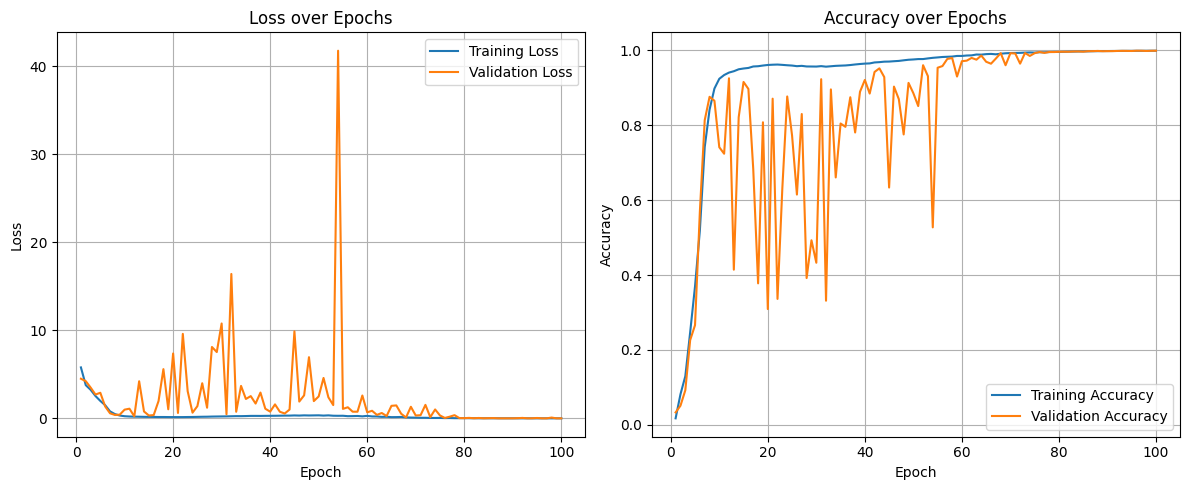

Plots generated successfully!


In [23]:
epochs_range = range(1, NUM_EPOCHS + 1) 
plt.figure(figsize=(12, 5)) # Tạo một hình vẽ mới với kích thước 12x5 inches
plt.subplot(1, 2, 1) # Tạo biểu đồ con thứ nhất (1 hàng, 2 cột)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2) # Tạo biểu đồ con thứ hai (1 hàng, 2 cột)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout() # Tự động điều chỉnh khoảng cách giữa các biểu đồ con để tránh chồng chéo
plt.show() # Hiển thị các biểu đồ
print("Plots generated successfully!")

In [24]:
# if __name__ == '__main__':
#     # --- 1. Cấu hình & Hyperparameters ---
#     DATA_DIR = '/workspace/data/npy_100'  # THAY ĐỔI ĐƯỜNG DẪN NÀY
#     NUM_CLASSES = 2139                         # THAY ĐỔI số lượng lớp (class) nếu cần
#     set_seed(42)  # Đặt seed toàn cục để đảm bảo tính tái lập
#     # Model Hyperparameters
#     # Với AdvancedGRUModel, các giá trị hidden_size và num_layers đã được định nghĩa
#     # cứng bên trong kiến trúc model, nên chúng ta không cần truyền vào nữa.
#     INPUT_SIZE = 3 * 61 * 1  # C * V * M
    
#     # Training Hyperparameters
#     NUM_EPOCHS = 200
#     BATCH_SIZE = 256
#     LEARNING_RATE = 0.001

#     # --- 2. Chuẩn bị Dữ liệu ---
#     # Tạo Datasets (phần này giữ nguyên)
#     train_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/train_data.npy',
#         label_path=f'{DATA_DIR}/train_label.pkl'
#     )
#     val_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/val_data.npy',
#         label_path=f'{DATA_DIR}/val_label.pkl'
#     )
#     test_dataset = SkeletonDataset(
#         data_path=f'{DATA_DIR}/test_data.npy',
#         label_path=f'{DATA_DIR}/test_label.pkl'
#     )

#     # Tạo DataLoaders (phần này giữ nguyên)
#     train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#     val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#     test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#     # --- 3. Khởi tạo Model, Loss, Optimizer ---
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"Using device: {device}")

#     # **THAY ĐỔI CHÍNH Ở ĐÂY**
#     # Khởi tạo model AdvancedGRUModel với các tham số cần thiết
#     model = AdvancedGRUModel(input_size=INPUT_SIZE, num_classes=NUM_CLASSES).to(device)
#     print("--- Model Architecture ---")
#     print(model)
#     print("--------------------------")

#     # Hàm mất mát và trình tối ưu hóa (giữ nguyên)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
#     train_losses = []
#     val_losses = []
#     train_accuracies = []
#     val_accuracies = []
    
#     # --- 4. Vòng lặp Huấn luyện --- (giữ nguyên)
#     for epoch in range(NUM_EPOCHS):
#         print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        
#         train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
#         print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

#         val_loss, val_acc = evaluate(model, val_loader, criterion, device)
#         print(f"Epoch {epoch+1} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         train_accuracies.append(train_acc)
#         val_accuracies.append(val_acc)

#     print("\n--- Training Finished ---")

#     # --- 5. Đánh giá cuối cùng trên tập Test --- (giữ nguyên)
#     test_loss, test_acc = evaluate(model, test_loader, criterion, device)
#     print(f"\nFinal Test Results | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

#     # (Tùy chọn) Lưu model
#     # torch.save(model.state_dict(), 'advanced_gru_model.pth')
#     # print("Model saved to advanced_gru_model.pth")